In [1]:
import pandas as pd
import numpy as np
import scipy 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choices,sample

import os
import gc
import pickle

from tqdm import tqdm

plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

os.chdir("../")
root_path = os.getcwd()

data_folder_path = os.path.join(root_path, 'data')
original_file_path = os.path.join(data_folder_path, 'original_data')
original_raw_file_path = os.path.join(original_file_path,'raw_data')
original_processed_file_path = os.path.join(original_file_path,'processed_data')

raw_file_folders = os.listdir(original_raw_file_path)

external_file_path = os.path.join(data_folder_path,'external_data')
external_raw_file_path = os.path.join(external_file_path,'raw_data')
external_processed_file_path = os.path.join(external_file_path,'processed_data')

c:\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# dataframe 가로로 여러개 보기
def multi_table(table_list):
    from IPython.core.display import HTML
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [3]:
cj_deliv = pd.read_csv(os.path.join(original_processed_file_path, 'CJ_delivery.csv'))

In [4]:
holiday = pd.to_datetime(['2019-02-04','2019-02-05','2019-02-06','2019-03-01','2019-05-06','2019-05-12','2020-04-15', '2020-04-30','2020-05-05'])

In [6]:
folder_path = os.path.join(original_processed_file_path, raw_file_folders[0])
card_files = [file for file in os.listdir(original_processed_file_path) if file.startswith('카드')]

df_list = []

for file_name in card_files:
    file_path = os.path.join(original_processed_file_path, file_name)
    df = pd.read_csv(file_path)
    df_list.append(df)
    
foreigner = df_list[1]
register = df_list[0]

cat_dict = {10 : '숙박',
20 : '레저용품',
21 : '레저업소',
22 : '문화취미',
30 : '가구',
31 : '전기',
32 : '주방용구',
33 : '연료판매',
34 : '광학제품',
35 : '가전',
40 : '유통업',
42 : '의복',
43 : '직물',
44 : '신변잡화',
50 : '서적문구',
52 : '사무통신',
60 : '자동차판매',
62 : '자동차 정비',
70 : '의료기관',
71 : '보건위생',
80 : '요식업소',
81 : '음료식품',
92 : '수리서비스'}

with open(os.path.join(original_processed_file_path,'card_code_to_name_dict.pickle'), 'rb') as f:
    card_code_to_dong_dict = pickle.load(f)

register['region_code'] = register.GU_CD.astype(str)+register.DONG_CD.astype(str)
register['HDONG_NM'] = register.region_code.map(card_code_to_dong_dict.get('행정동명'))
register['MCT_CAT_NM'] = register.MCT_CAT_CD.map(cat_dict)

register['STD_DD'] = pd.to_datetime(register['STD_DD'], format='%Y%m%d')

register['year'] = register['STD_DD'].dt.year.values
register['month'] = register['STD_DD'].dt.month.values
register['weekofyear'] = register['STD_DD'].dt.weekofyear.values
register['dayofweek'] = register['STD_DD'].dt.dayofweek.values

register['weekday'] = np.where(register.dayofweek<5,'평일','주말')

c:\python37\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [7]:
register.loc[register.STD_DD.isin(holiday),'weekday'] = '주말'

In [8]:
covid_df = pd.read_csv(os.path.join(external_processed_file_path,'covid19_일별확진자.csv'))
covid_df['날짜'] = pd.to_datetime(covid_df.날짜)

covid_df = covid_df.iloc[8:129]

In [9]:
cj_deliv['DL_YMD'] = pd.to_datetime(cj_deliv.DL_YMD.apply(lambda x : '20'+str(x)), format='%Y%m%d')

cj_deliv['year'] = cj_deliv.DL_YMD.dt.year.values
cj_deliv['month'] = cj_deliv.DL_YMD.dt.month.values
cj_deliv['weekofyear'] = cj_deliv.DL_YMD.dt.weekofyear.values
cj_deliv['dayofweek'] = cj_deliv.DL_YMD.dt.dayofweek.values

cj_deliv['weekday'] = np.where(cj_deliv.dayofweek < 5, '평일', '주말')

In [11]:
# 휴일의 경우 주말과 같이 처리
cj_deliv.loc[cj_deliv.DL_YMD.isin(holiday),'weekday'] = '주말'

### 물류 송장건수

In [12]:
total = cj_deliv.groupby(['year']).INVC_CONT.mean().reset_index()
total['CTPV_NM'] = '전체'

Text(0.5, 1.0, '일별 평균 송장건수')

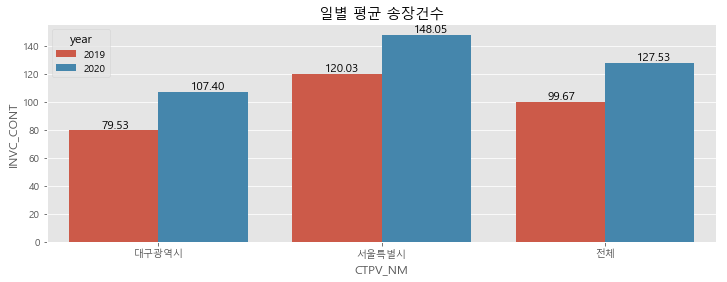

In [13]:
tmp = pd.concat([cj_deliv.groupby(['CTPV_NM','year']).INVC_CONT.mean().reset_index(),total])

fig ,ax = plt.subplots(figsize=(12,4))
sns.barplot(
    data = tmp,
    x = 'CTPV_NM',
    y = 'INVC_CONT',
    hue = 'year'
)
ax.patches[0]
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x()+p.get_width()/3+0.01, p.get_height()+2), fontsize=11.5)

ax.set_title('일별 평균 송장건수')

In [15]:
tmp_df = cj_deliv.groupby(['DL_YMD','CTPV_NM','CTGG_NM'])['INVC_CONT'].sum().reset_index()
# tmp_df = cj_deliv.groupby(['DL_YMD','CTPV_NM','CTGG_NM','DL_GD_LCLS_NM'])['INVC_CONT'].sum().reset_index()

대구광역시 수성구


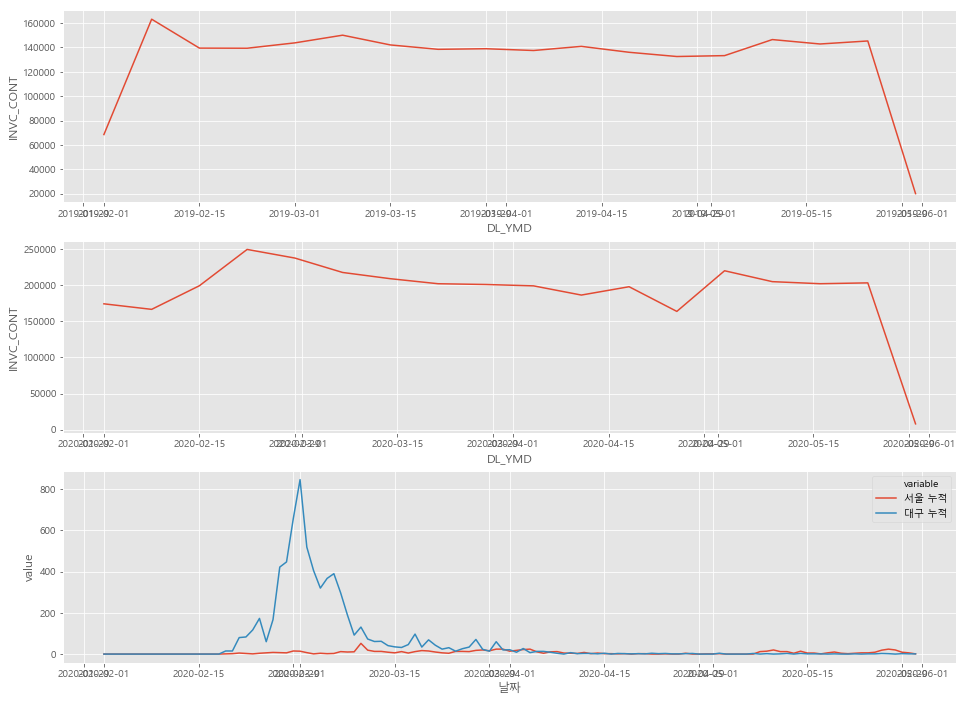

대구광역시 중구


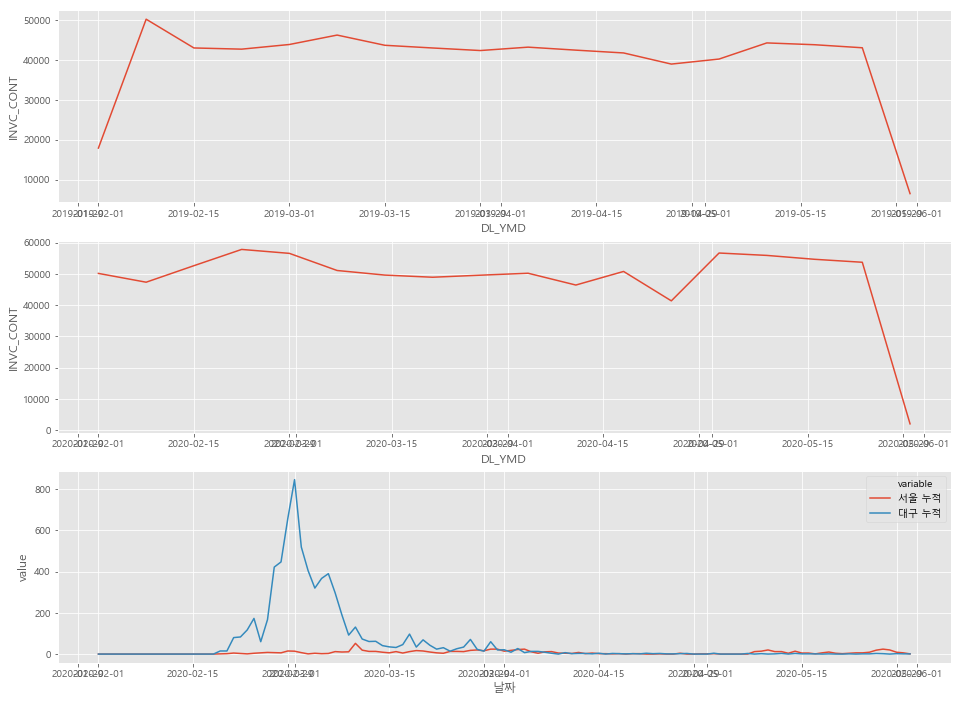

서울특별시 노원구


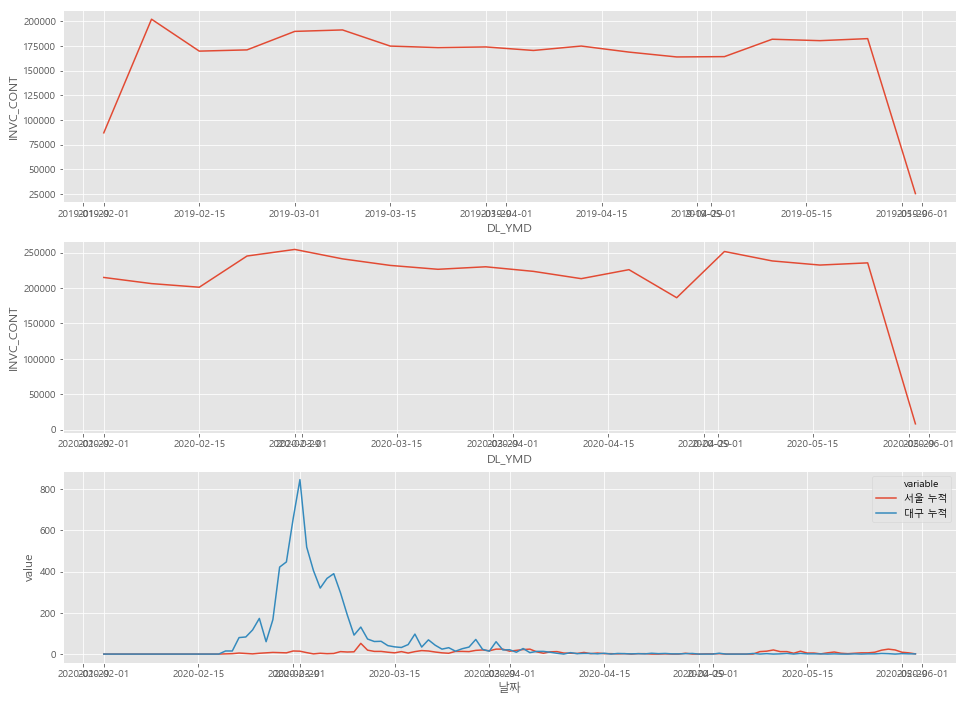

서울특별시 중구


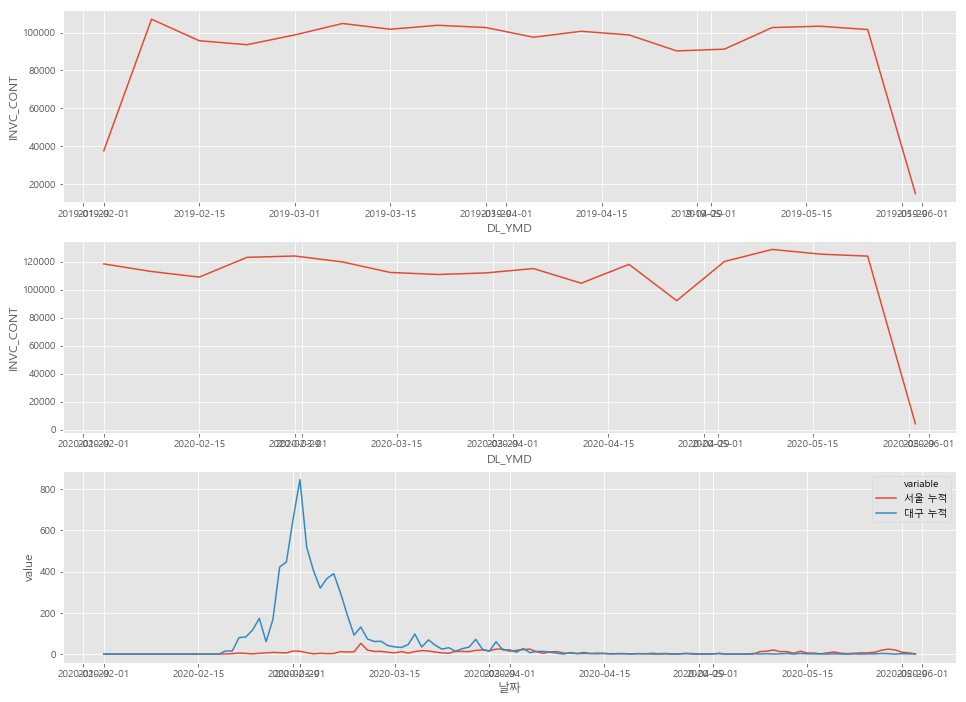

In [16]:
for si,gu in tmp_df.drop_duplicates(['CTPV_NM','CTGG_NM'])[['CTPV_NM','CTGG_NM']].values:
    print(f'{si} {gu}')
    tmp = tmp_df.loc[(tmp_df.CTPV_NM == si) & (tmp_df.CTGG_NM==gu) & (tmp_df.DL_YMD.dt.year==2020)]
    tmp1 = tmp_df.loc[(tmp_df.CTPV_NM == si) & (tmp_df.CTGG_NM==gu) & (tmp_df.DL_YMD.dt.year==2019)]
    
    plt.figure(figsize=(16,12))
    plt.subplot(311)
    sns.lineplot(
        data = tmp1.set_index('DL_YMD').resample('7D').sum().reset_index(),
        x = 'DL_YMD',
        y = 'INVC_CONT',
        #hue = 'DL_GD_LCLS_NM'
    )
    
    plt.subplot(312)
    sns.lineplot(
        data = tmp.set_index('DL_YMD').resample('7D').sum().reset_index(),
        x = 'DL_YMD',
        y = 'INVC_CONT',
        #hue = 'DL_GD_LCLS_NM'
    )
    
    plt.subplot(313)
    sns.lineplot(
        data = covid_df.iloc[:,[0,1,3]].melt(id_vars='날짜'),
        x = '날짜',
        y = 'value',
        hue = 'variable'
    )
    
    plt.show()

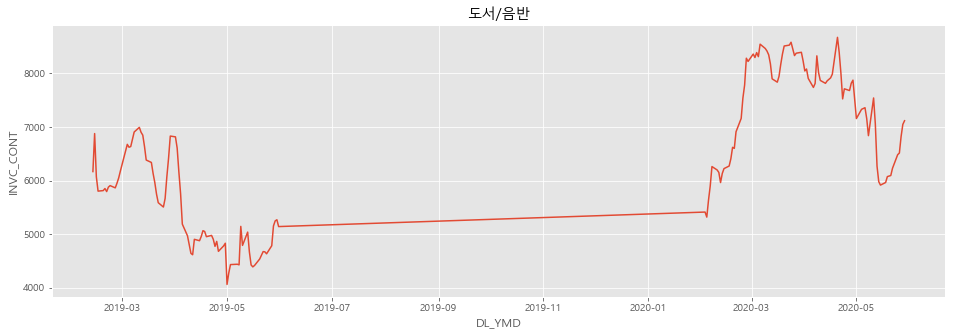

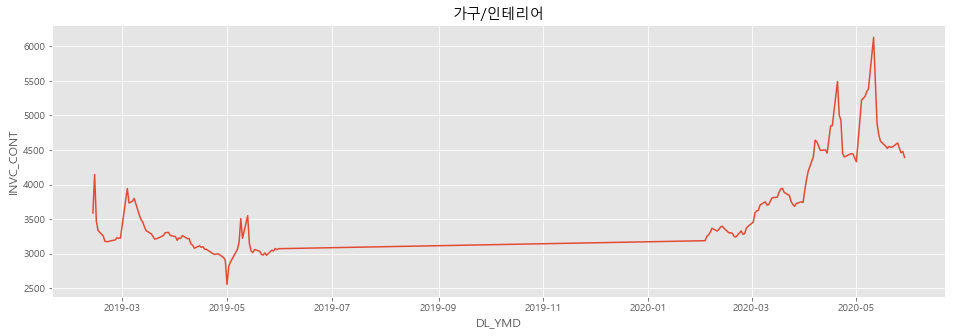

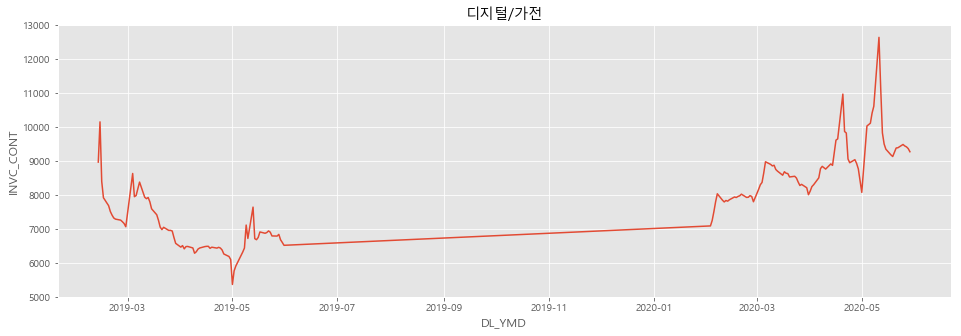

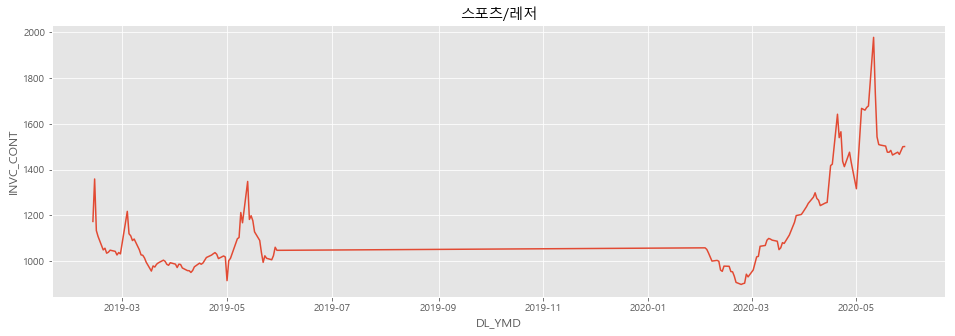

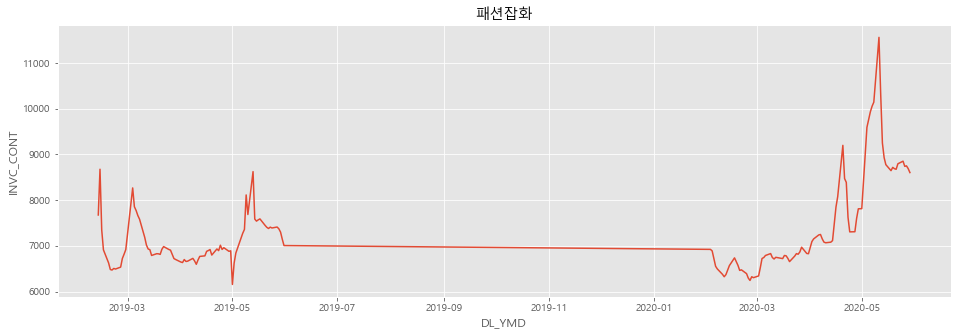

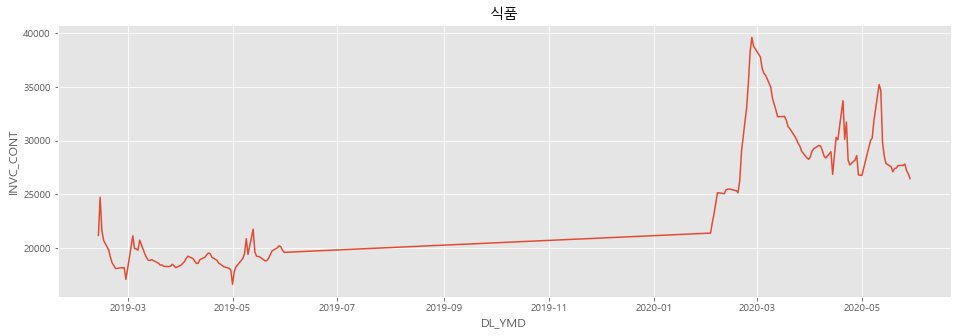

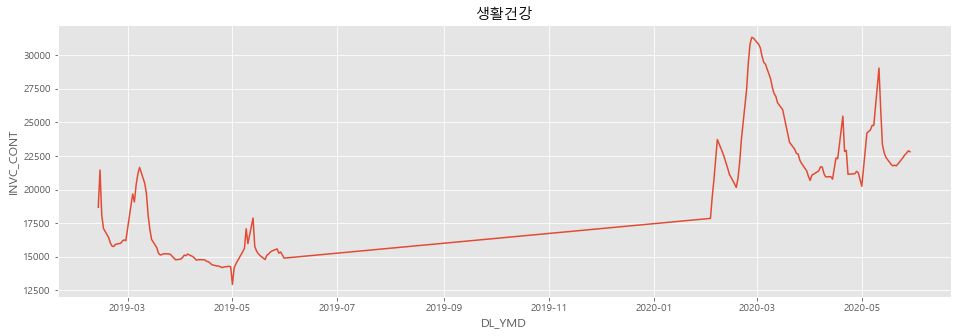

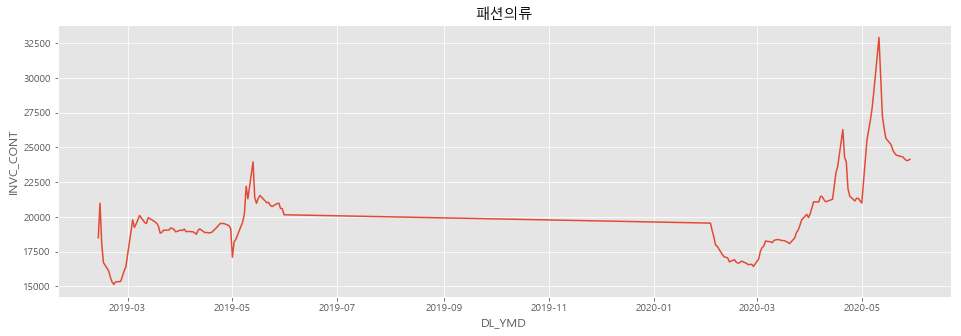

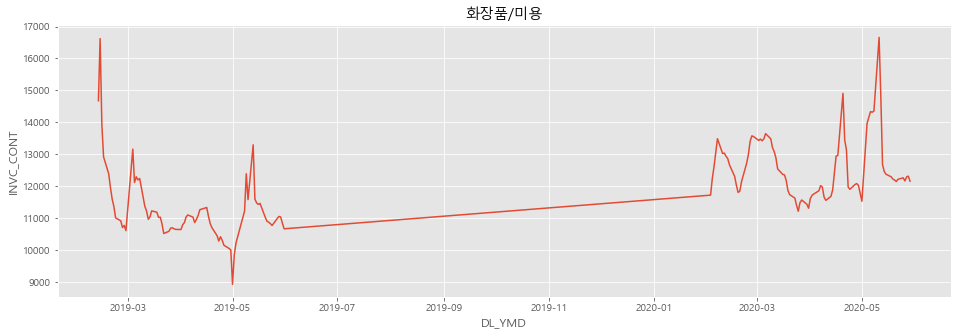

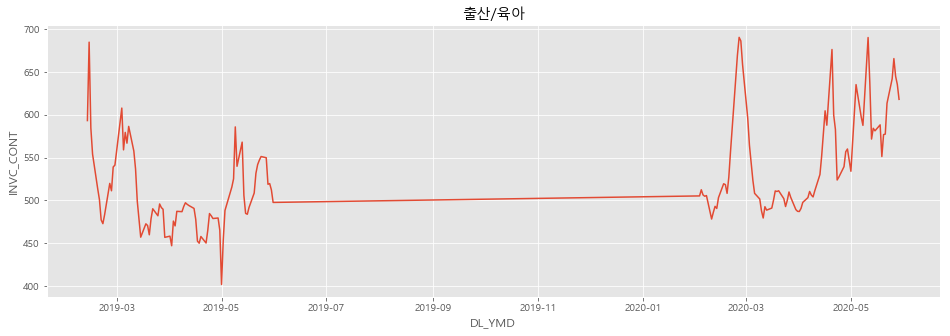

In [17]:
for cat in cj_deliv.DL_GD_LCLS_NM.unique():
    
    plt.figure(figsize=(16,5))
    sns.lineplot(
        x=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM==cat)].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna().index,
        y=cj_deliv.loc[(cj_deliv.weekday == '평일') & (cj_deliv.DL_GD_LCLS_NM==cat)].groupby('DL_YMD')['INVC_CONT'].sum().rolling(window=5).mean().dropna()
    )
    plt.title(cat)
    plt.show()

In [18]:
tmp_df = cj_deliv.loc[(cj_deliv.weekday == '평일')].groupby(['DL_GD_LCLS_NM','DL_YMD','year','weekofyear'])['INVC_CONT'].sum().reset_index()

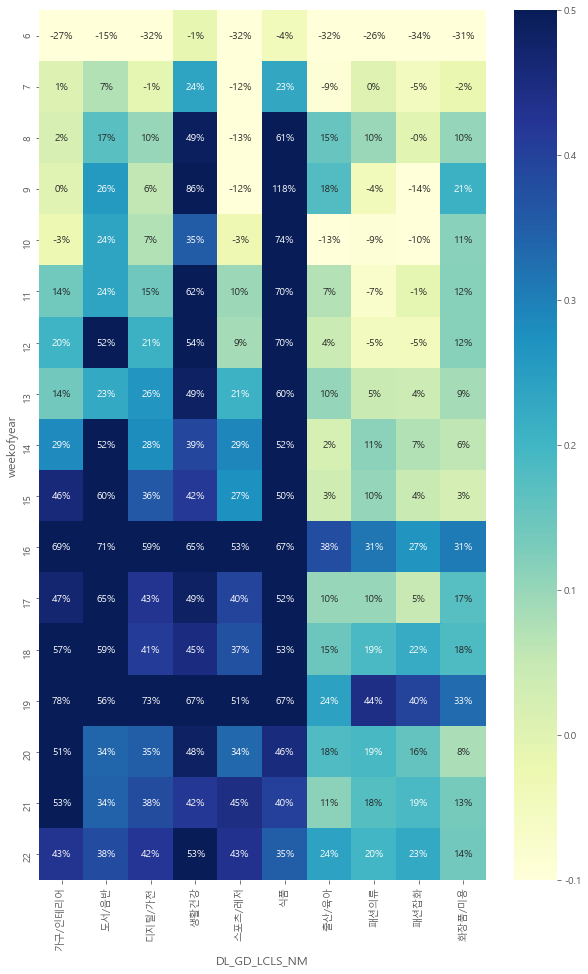

In [19]:
plt.figure(figsize=(10,16))
sns.heatmap(
    tmp_df.groupby(['DL_GD_LCLS_NM','year','weekofyear'])['INVC_CONT'].mean().\
        reset_index().\
        groupby(['DL_GD_LCLS_NM','weekofyear']).\
        apply(lambda x : (x.iloc[1,-1]-x.iloc[0,-1])/x.iloc[0,-1] if x.shape[0]==2 else 1).\
        reset_index(name='rate').\
        pivot('weekofyear','DL_GD_LCLS_NM','rate').\
        iloc[1:,:],
    cmap='YlGnBu', annot=True,vmin=-.1, vmax=.5, fmt='.0%'
)

* 송장건수
    * [가구/인테리어, 도서/음반, 디지털/가전, 생활건강, 스포츠/레저, 식품] 의 경우 전년 동주 대비 증가율이 높은편
    * [출산/육아, 패션의류, 패션잡화, 화장품/미용] 의 경우 전년동주 대비 증가율이 높지 않음

In [20]:
from sklearn.cluster import KMeans

In [21]:
km_clst = KMeans(n_clusters=3)

In [22]:
tmp_pivot=tmp_df.groupby(['DL_GD_LCLS_NM','year','weekofyear'])['INVC_CONT'].mean().\
        reset_index().\
        groupby(['DL_GD_LCLS_NM','weekofyear']).\
        apply(lambda x : (x.iloc[1,-1]-x.iloc[0,-1])/x.iloc[0,-1] if x.shape[0]==2 else 1).\
        reset_index(name='rate').\
        pivot('DL_GD_LCLS_NM','weekofyear','rate').iloc[:,1:]

In [23]:
tmp_pivot['cluster']=km_clst.fit_predict(tmp_pivot)

In [24]:
tmp_pivot

weekofyear,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,cluster
DL_GD_LCLS_NM,,,,,,,,,,,,,,,,,,
가구/인테리어,-0.268166,0.009534,0.018656,0.001726,-0.025257,0.143209,0.204599,0.141185,0.286661,0.459725,0.693706,0.468037,0.574740,0.777769,0.512288,0.526602,0.429473,2
도서/음반,-0.151937,0.072352,0.170059,0.257418,0.237284,0.237292,0.523073,0.226293,0.523868,0.604397,0.713879,0.647775,0.588771,0.556430,0.339402,0.344384,0.383957,2
디지털/가전,-0.316706,-0.007622,0.100699,0.055542,0.071292,0.145786,0.210065,0.263681,0.279789,0.360288,0.594858,0.428334,0.408880,0.728625,0.352252,0.381647,0.422108,2
생활건강,-0.012578,0.235574,0.491397,0.857484,0.354349,0.624802,0.544629,0.485716,0.391443,0.416640,0.653546,0.485768,0.448920,0.669008,0.484311,0.419006,0.531676,1
스포츠/레저,-0.315692,-0.116766,-0.134109,-0.116358,-0.028806,0.096807,0.085616,0.207126,0.290276,0.274088,0.531877,0.396797,0.373173,0.508347,0.335697,0.445015,0.432334,2
식품,-0.041129,0.230331,0.605378,1.178598,0.740418,0.704192,0.701942,0.596322,0.520034,0.500561,0.670783,0.519677,0.532190,0.674510,0.455350,0.402880,0.350140,1
출산/육아,-0.318598,-0.091697,0.153146,0.180287,-0.133356,0.069147,0.042840,0.102452,0.021346,0.034818,0.378877,0.101086,0.147583,0.242637,0.181781,0.112845,0.241961,0
패션의류,-0.256731,0.003351,0.097790,-0.040796,-0.091903,-0.072200,-0.050658,0.045149,0.112369,0.101858,0.314200,0.100773,0.189263,0.441774,0.190828,0.176534,0.198061,0
패션잡화,-0.338272,-0.049806,-0.002680,-0.141222,-0.104574,-0.006952,-0.047057,0.040238,0.072800,0.044090,0.267139,0.049753,0.222047,0.398942,0.156265,0.189975,0.227767,0


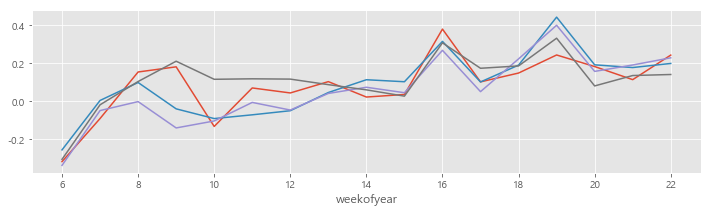

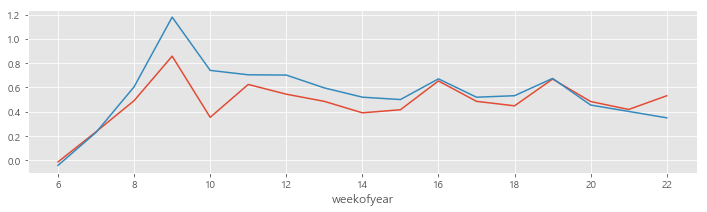

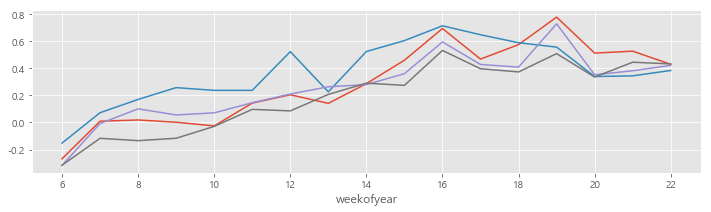

In [25]:
for i in range(3):
    data = tmp_pivot.loc[tmp_pivot.cluster==i]
    fig, ax = plt.subplots(figsize=(12,3))
    for j in range(data.shape[0]):
        data.T.iloc[:-1,j].plot(ax=ax)
    plt.show()

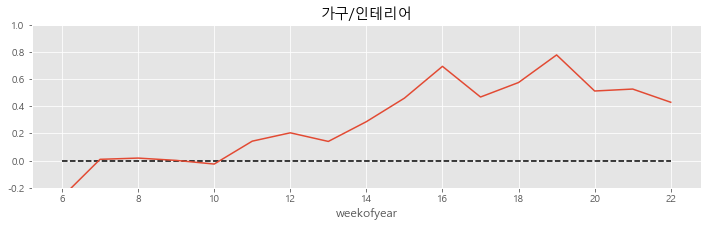

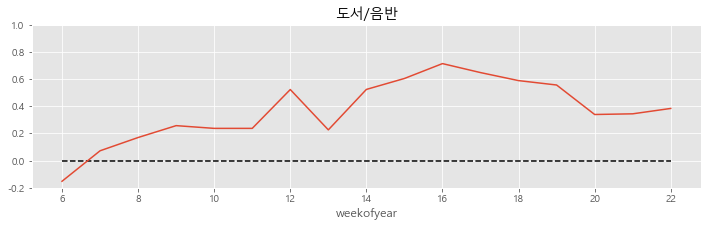

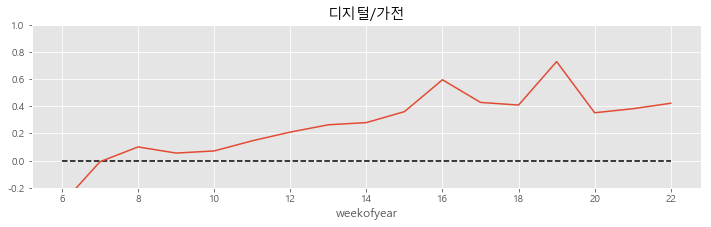

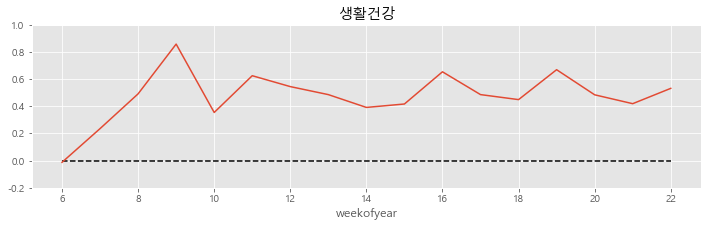

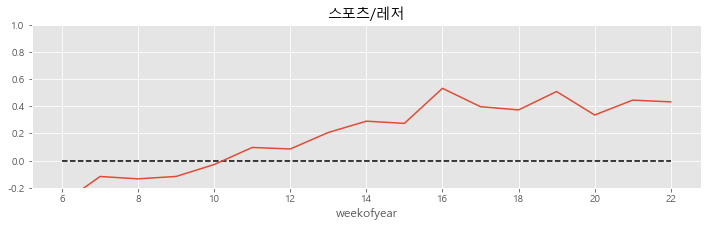

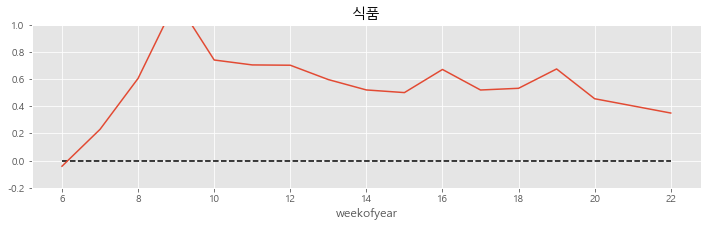

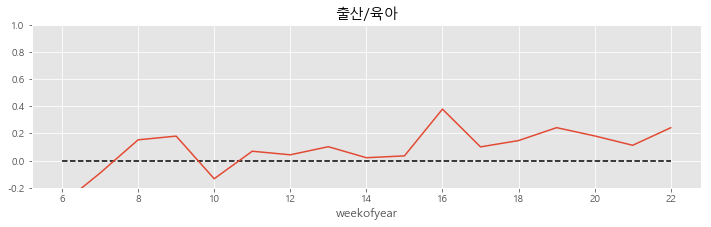

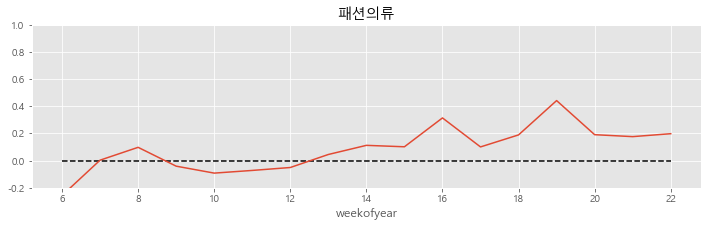

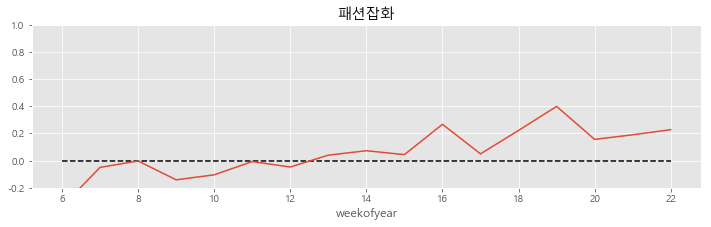

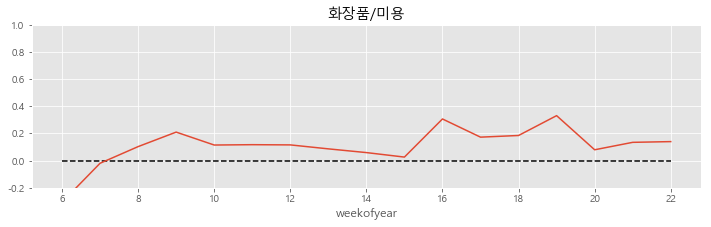

In [26]:
for col in tmp_df.DL_GD_LCLS_NM.unique():
    tmp_df.groupby(['DL_GD_LCLS_NM','year','weekofyear'])['INVC_CONT'].mean().\
            reset_index().\
            groupby(['DL_GD_LCLS_NM','weekofyear']).\
            apply(lambda x : (x.iloc[1,-1]-x.iloc[0,-1])/x.iloc[0,-1] if x.shape[0]==2 else 1).\
            reset_index(name='rate').\
            pivot('weekofyear','DL_GD_LCLS_NM','rate').\
            iloc[1:,:].loc[:,col].\
            plot(figsize=(12,3))
    plt.hlines(xmin=6, xmax=22, y=0, linestyles='--')
    plt.ylim(-0.2, 1)
    plt.title(col)
    plt.show()

In [ ]:
# 월별 송장건수
g = sns.FacetGrid(data=cj_deliv.groupby(['CTPV_NM','year','weekofyear'])['INVC_CONT'].sum().reset_index(), col='year', row='CTPV_NM',aspect=3)
g.map(sns.pointplot, 'weekofyear', 'INVC_CONT')

c:\python37\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


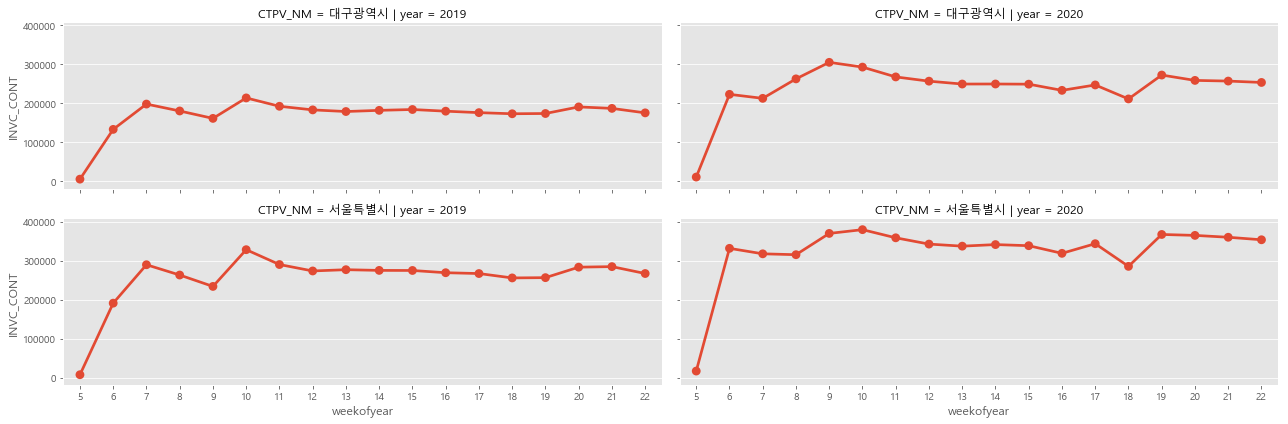

In [44]:
# 월별 송장건수
g = sns.FacetGrid(data=cj_deliv.groupby(['CTPV_NM','year','month'])['INVC_CONT'].sum().reset_index(), col='year', row='CTPV_NM',aspect=3)
g.map(sns.pointplot, 'month', 'INVC_CONT')

([<matplotlib.axis.XTick at 0x2c528e5c908>,
 <a list of 5 Text xticklabel objects>)

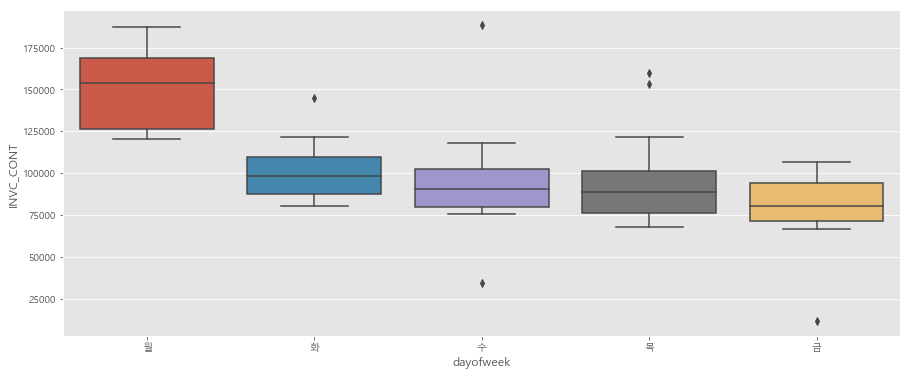

In [35]:
plt.figure(figsize=(15,6))
sns.boxplot(
    data = cj_deliv.loc[(cj_deliv.weekday == '평일')].groupby(['year','month','weekofyear','dayofweek'])['INVC_CONT'].sum().reset_index(),
    x = 'dayofweek',
    y = 'INVC_CONT'
)

plt.xticks(ticks=[0,1,2,3,4], labels=['월','화','수','목','금'])

___

### INDEX

In [27]:
register.groupby(['year','weekofyear'])['STD_DD'].apply(lambda x: list(x.unique()))

year  weekofyear
2019  5             [2019-02-01T00:00:00.000000000, 2019-02-02T00:...
      6             [2019-02-04T00:00:00.000000000, 2019-02-05T00:...
      7             [2019-02-11T00:00:00.000000000, 2019-02-12T00:...
      8             [2019-02-18T00:00:00.000000000, 2019-02-19T00:...
      9             [2019-02-25T00:00:00.000000000, 2019-02-26T00:...
      10            [2019-03-04T00:00:00.000000000, 2019-03-05T00:...
      11            [2019-03-11T00:00:00.000000000, 2019-03-12T00:...
      12            [2019-03-18T00:00:00.000000000, 2019-03-19T00:...
      13            [2019-03-25T00:00:00.000000000, 2019-03-26T00:...
      14            [2019-04-01T00:00:00.000000000, 2019-04-02T00:...
      15            [2019-04-08T00:00:00.000000000, 2019-04-09T00:...
      16            [2019-04-15T00:00:00.000000000, 2019-04-16T00:...
      17            [2019-04-22T00:00:00.000000000, 2019-04-23T00:...
      18            [2019-04-29T00:00:00.000000000, 2019-04-30T00:...
   

In [ ]:
# INDEX 기간 18주까지
# 시작주 8주차 (2월 17일-2월23일)
# 마지막주차 17주차 : 
# 18주차->19년 어린이날로 인해 평일 평균 송장건수가 높아짐.
# 19주차->20년 어린이날로 인해 평일 평균 송장건수 높아짐.
# 20주차~ -> 재난지원금지원으로 인해 정보들이 너무 희석됨

**Impact Index**  
$r_w,_d$ : w주차, d번째 요일의 19년대비 20년도 송장건수 비율 (d번째 요일 - d = 0:월, 1:화, ..., 6:일)  
$post_r=Max(\{r_w,_d | w \in [8,11], d \in [0,6]\})$    
$pre_r=Mean(\{r_w,_d | w=7, d \in [0,6]\})$  
  
$Impact Index = {post_r-pre_r \over pre_r}$

In [28]:
def Impact_Index(df):
    #코로나 이후(2.19 ~ 3.15사이) 전년대비 송장건수 비율의 최댓값
    post_r = df.loc[df.weekday=='평일'].\
            groupby(['DL_GD_LCLS_NM','year','weekofyear','dayofweek'])['INVC_CONT'].sum().\
            reset_index().\
            groupby(['DL_GD_LCLS_NM','weekofyear','dayofweek']).\
            apply(lambda x : (x.iloc[1,-1]/x.iloc[0,-1]) if x.shape[0]==2 else 1).\
            reset_index(name='rate').\
            query('weekofyear>=8 & weekofyear<=11 & rate!=1').\
            groupby('DL_GD_LCLS_NM')['rate'].max()

    #코로나 이전 전년대비 송장건수 비율 평균
    pre_r = df.loc[df.weekday=='평일'].\
            groupby(['DL_GD_LCLS_NM','year','weekofyear','dayofweek'])['INVC_CONT'].sum().\
            reset_index().\
            groupby(['DL_GD_LCLS_NM','weekofyear','dayofweek']).\
            apply(lambda x : (x.iloc[1,-1]/x.iloc[0,-1]) if x.shape[0]==2 else 1).\
            reset_index(name='rate').\
            query('weekofyear==7 & rate!=1').\
            groupby('DL_GD_LCLS_NM')['rate'].mean()
            
    index = (post_r-pre_r)/pre_r
    
    return dict(index)

**Growth Index**  
$r_w,_d$ : w주차, d번째 요일의 19년대비 20년도 송장건수 비율 (d번째 요일 - d = 0:월, 1:화, ..., 6:일)  
$GrowthIndex={\sum_{i=1}^N i \cdot r_i \over \sum_{i=1}^N i} \ s.t\ N : size \ of\ \{r_w,_d |\ d \in [12,17]\},\ r_i: i'th\ element\ of\ \{r_w,_d |\ d \in [12,17]\} \ ordered \ by \ date$ 

In [29]:
def growth_index(df):
    
    def moving_avg(arr):
        values=arr.rate.values
        weights=np.array(range(1,len(values)+1))
        return np.dot(values, weights) /sum(weights)
    
    index = df.loc[df.weekday=='평일'].\
        groupby(['DL_GD_LCLS_NM','year','weekofyear','dayofweek'])['INVC_CONT'].sum().\
        reset_index().\
        groupby(['DL_GD_LCLS_NM','weekofyear','dayofweek']).\
        apply(lambda x : (x.iloc[1,-1]/x.iloc[0,-1]) if x.shape[0]==2 else 1).\
        reset_index(name='rate').\
        query('rate!=1 & weekofyear>=12 & weekofyear <=17').\
        groupby('DL_GD_LCLS_NM').\
        apply(moving_avg)
    
    return dict(index)

In [30]:
impact_index=Impact_Index(cj_deliv)

In [31]:
growth_index=growth_index(cj_deliv)

In [33]:
index_df = pd.DataFrame.from_dict(impact_index, orient='index',columns=['impact_index']).reset_index().merge(pd.DataFrame.from_dict(growth_index, orient='index',columns=['growth_index']).reset_index())

In [34]:
index_df

,index,impact_index,growth_index
0,가구/인테리어,0.268795,1.464825
1,도서/음반,0.380106,1.615584
2,디지털/가전,0.313698,1.408551
3,생활건강,0.629777,1.485732
4,스포츠/레저,0.307448,1.354191
5,식품,1.752602,1.561562
6,출산/육아,0.501547,1.126681
7,패션의류,0.094383,1.133107
8,패션잡화,0.122351,1.090680
9,화장품/미용,0.392453,1.139041


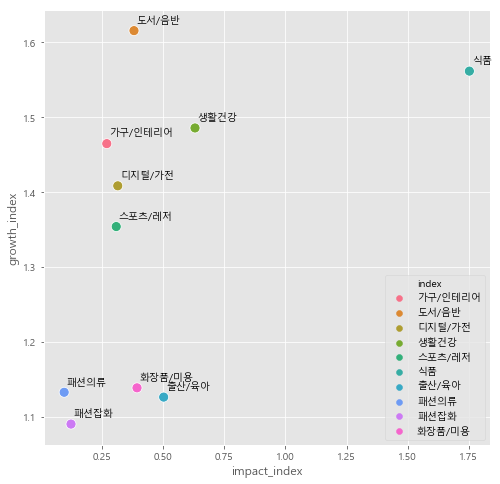

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(
    data = index_df,
    x = 'impact_index',
    y = 'growth_index',
    hue = 'index',
    s = 100,
    ax = ax
)

for i in range(index_df.shape[0]):
    ax.annotate(index_df.iloc[i,0], (index_df.iloc[i,1]+0.01, index_df.iloc[i,2]+0.01))

In [36]:
pd.DataFrame.from_dict(growth_index, orient='index',columns=['growth_index'])

,growth_index
가구/인테리어,1.464825
도서/음반,1.615584
디지털/가전,1.408551
생활건강,1.485732
스포츠/레저,1.354191
식품,1.561562
출산/육아,1.126681
패션의류,1.133107
패션잡화,1.090680
화장품/미용,1.139041


In [37]:
impact_index

{'가구/인테리어': 0.2687953594916788,
 '도서/음반': 0.3801055600974125,
 '디지털/가전': 0.3136976473470359,
 '생활건강': 0.6297772762344486,
 '스포츠/레저': 0.30744756465290374,
 '식품': 1.7526022914433594,
 '출산/육아': 0.5015470053012648,
 '패션의류': 0.09438340987789043,
 '패션잡화': 0.12235114690466754,
 '화장품/미용': 0.3924533071846987}

___

### 카드소비와 물류량 간의 상관관계

In [41]:
# 코로나 관련 기간 정의
normal_case = pd.date_range(start='2019-02-01', end='2020-02-20') # 코로나 이전 시기
covid_spread = pd.date_range(start='2020-02-21', end='2020-03-15') # 코로나 확산시기 / 하루 확진자 100명 이상
covid_ease = pd.date_range(start='2020-03-22', end='2020-05-05') #코로나 확산 1주일 후 ~ 생활속 거리두기 시행전
covid_resilence = pd.date_range(start='2020-05-06', end='2020-05-31') # 생활속 거리두기 시행

In [42]:
register['SI_NM'] = register.HDONG_NM.map(dict(cj_deliv.drop_duplicates('HDNG_NM', keep='last').set_index('HDNG_NM')['CTPV_NM']))

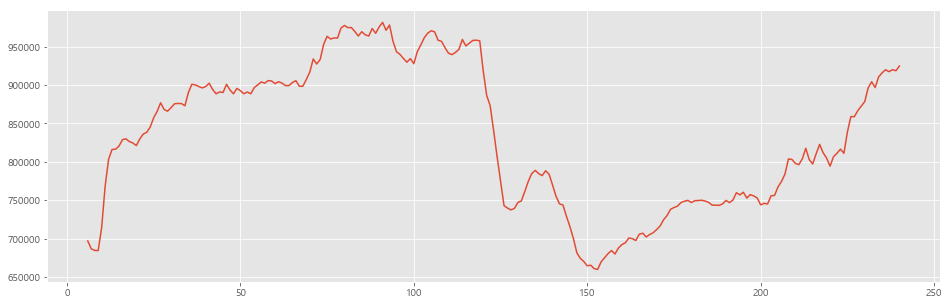

In [43]:
register.loc[register.SI_NM=='서울특별시'].groupby(['STD_DD'])['USE_CNT'].sum().reset_index().USE_CNT.rolling(window=7).mean().plot(figsize=(16,5))

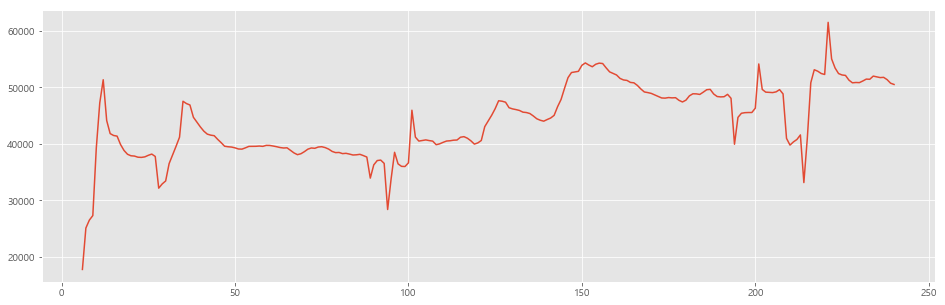

In [44]:
cj_deliv.loc[cj_deliv.CTPV_NM=='서울특별시'].groupby(['DL_YMD'])['INVC_CONT'].sum().reset_index().INVC_CONT.rolling(window=7).mean().plot(figsize=(16,5))

Text(0.5, 1.0, '서울특별시 - 송장건수 및 소비횟수')

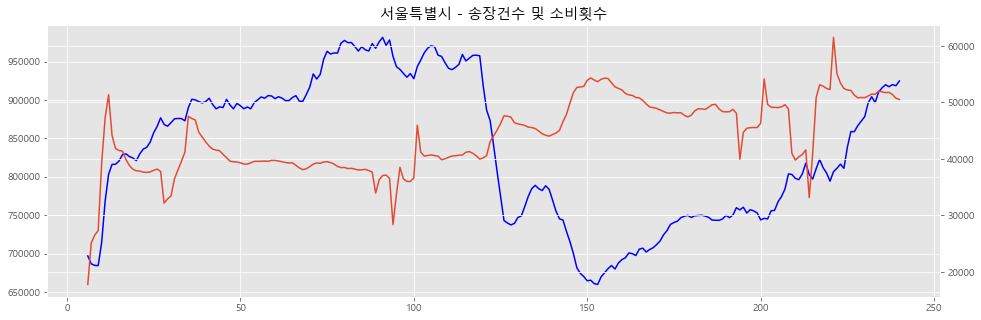

In [45]:
fig, ax = plt.subplots(figsize=(16,5))
register.loc[register.SI_NM=='서울특별시'].groupby(['STD_DD'])['USE_CNT'].sum().reset_index().USE_CNT.rolling(window=7).mean().dropna().plot(ax=ax, color='b')
g = ax.twinx()
g = cj_deliv.loc[cj_deliv.CTPV_NM=='서울특별시'].groupby(['DL_YMD'])['INVC_CONT'].sum().reset_index().INVC_CONT.rolling(window=7).mean().dropna().plot()

ax.set_title('서울특별시 - 송장건수 및 소비횟수')

Text(0.5, 1.0, '대구광역시 - 송장건수 및 소비횟수')

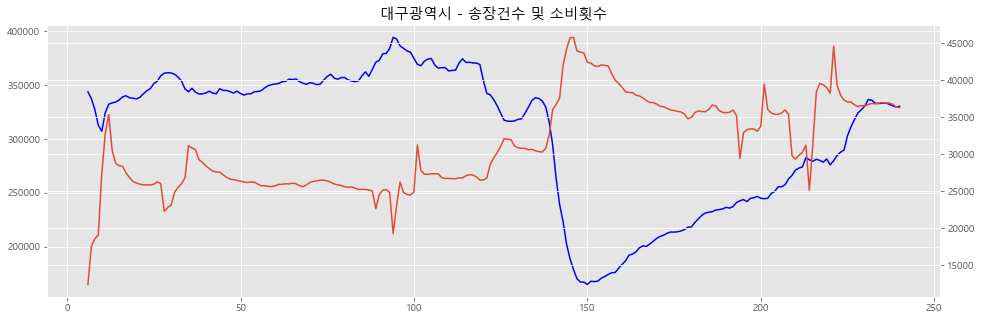

In [46]:
fig, ax = plt.subplots(figsize=(16,5))
register.loc[register.SI_NM=='대구광역시'].groupby(['STD_DD'])['USE_CNT'].sum().reset_index().USE_CNT.rolling(window=7).mean().plot(ax=ax, color='b')
g = ax.twinx()
g = cj_deliv.loc[cj_deliv.CTPV_NM=='대구광역시'].groupby(['DL_YMD'])['INVC_CONT'].sum().reset_index().INVC_CONT.rolling(window=7).mean().plot()
ax.set_title('대구광역시 - 송장건수 및 소비횟수')

Text(0.5, 1.0, '서울특별시 - 송장건수 및 소비횟수')

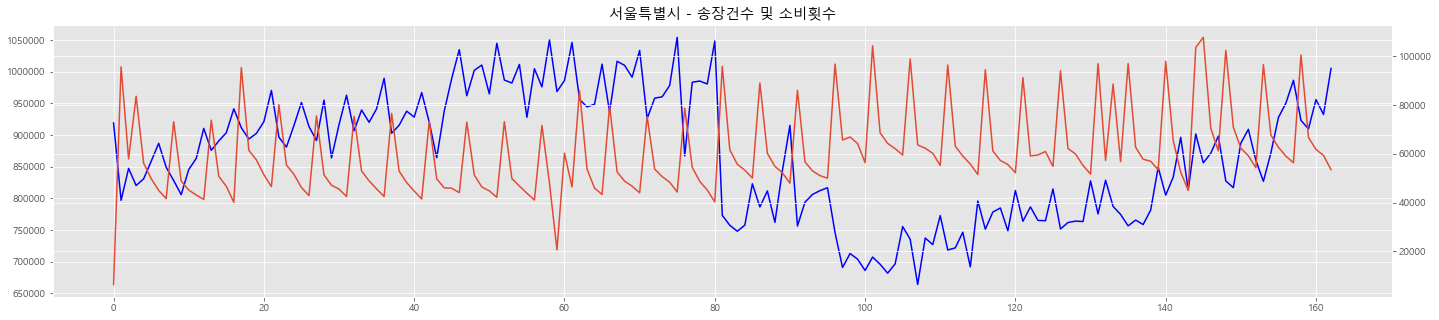

In [47]:
fig, ax = plt.subplots(figsize=(24,5))
register.loc[(register.SI_NM=='서울특별시') & (register.weekday=='평일')].groupby(['STD_DD'])['USE_CNT'].sum().reset_index().USE_CNT.plot(ax=ax, color='b')
g = ax.twinx()
g = cj_deliv.loc[(cj_deliv.CTPV_NM=='서울특별시') & (cj_deliv.weekday=='평일')].groupby(['DL_YMD'])['INVC_CONT'].sum().reset_index().INVC_CONT.plot()

ax.set_title('서울특별시 - 송장건수 및 소비횟수')

In [60]:
corr_2019=register.query('weekofyear!=5').\
        groupby(['year','weekofyear'])['USE_CNT'].sum().\
        reset_index().\
        merge(
                cj_deliv.query('weekofyear!=5').\
                        groupby(['year','weekofyear'])['INVC_CONT'].sum().\
                        reset_index()
        ).query('year==2019').\
        iloc[:,2:].\
        corr()

In [61]:
register.query('weekofyear!=5').\
        groupby(['year','weekofyear'])['USE_CNT'].sum().\
        reset_index().\
        merge(
                cj_deliv.query('weekofyear!=5').\
                        groupby(['year','weekofyear'])['INVC_CONT'].sum().\
                        reset_index()
        ).query('year==2019').\
        iloc[:-1,2:].\
        corr()

,USE_CNT,INVC_CONT
USE_CNT,1.00000,0.47441
INVC_CONT,0.47441,1.00000


In [62]:
corr_2020=register.query('weekofyear!=5').\
        groupby(['year','weekofyear'])['USE_CNT'].sum().\
        reset_index().\
        merge(
                cj_deliv.query('weekofyear!=5').\
                        groupby(['year','weekofyear'])['INVC_CONT'].sum().\
                        reset_index()
        ).query('year==2020').\
        iloc[:,2:].\
        corr()

In [63]:
register.query('weekofyear!=5').\
        groupby(['year','weekofyear'])['USE_CNT'].sum().\
        reset_index().\
        merge(
                cj_deliv.query('weekofyear!=5').\
                        groupby(['year','weekofyear'])['INVC_CONT'].sum().\
                        reset_index()
        ).query('year==2020').\
        iloc[:-1,2:].\
        corr()

,USE_CNT,INVC_CONT
USE_CNT,1.000000,-0.399213
INVC_CONT,-0.399213,1.000000


In [64]:
multi_table([corr_2019, corr_2020])

,USE_CNT,INVC_CONT
USE_CNT,1.000000,0.383338
INVC_CONT,0.383338,1.000000
,USE_CNT,INVC_CONT
USE_CNT,1.000000,-0.317526
INVC_CONT,-0.317526,1.000000
